In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.activations import sigmoid, linear, relu
from tensorflow.math import add, subtract
from tensorflow.linalg import matmul

tf.__version__

2022-03-12 19:25:27.969833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-12 19:25:27.969896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.8.0'

## Differential equation
$$\frac{d^2\psi}{dx^2} + \frac{1}{5}\frac{d\psi}{dx} + \psi= -\frac{1}{5}e^{-\frac{x}{5}}\cos{(x)}$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples

In [2]:
def analytic_sol(x):
    psi = tf.multiply(tf.exp(-x/5),tf.sin(x))
    return psi

## Implementation Neural Network model

Neural Network with one hidden layer with 10 hidden units and sigmoid activation, and one linear output unit.

### Initialize random parameters and compute forward propagation

In [3]:
def initialize_parameters(shapes):
    '''
        Initialize parameters for Neural Network
        
        Input: 
        shape -- list of sizes for parameters
        
        Return:
        parameters --  dictionary of tensors W1,b1,W2,b2,..... 
    '''
    n_x, n_h, n_y = shapes
    
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    W1 = tf.Variable(initializer(shape=(n_h,n_x)))
    b1 = tf.Variable(initializer(shape=(n_h,1)))
    W2 = tf.Variable(initializer(shape=(n_y,n_h)))
    b2 = tf.Variable(initializer(shape=(n_y,1)))
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    
    return parameters

In [12]:
def forward_propagation(X, parameters):
    '''
        Forward propagation for model LINEAR -> SIGMOID -> LINEAR -> LINEAR
        
        Inputs:
        X -- input dataset with discrete points of domain of differential equation
        
        Return:
        N -- single output feedforward neural network
    '''
    
    cache = []
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = add(tf.linalg.matmul(W1,X),b1)
    A1 = sigmoid(Z1)
    Z2 = add(tf.linalg.matmul(W2,A1),b2) # its posible compute with bias term b2
    #Z2 = tf.linalg.matmul(W2,A1)
    A2 = linear(Z2)
    
    cache.append(A1)
    
    return A2, cache

### Cost function

In [13]:
def compute_cost(X, N, cache, parameters):
    '''
        Compute the cost function of differential equation
        
        Inputs:
        N -- output of forward propagation
        
        Return:
        cost -- tensor of the cost function
    '''
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    A1 = cache[0]
    
    psi = X + tf.multiply(tf.square(X), N)
    dN_dx = tf.multiply(matmul(W2, W1), tf.multiply(A1, 1-A1))
    d2N_dx2 = tf.multiply(matmul(W2, tf.square(W1)), tf.multiply(tf.multiply(A1, 1-A1), 1-2*A1))
    dpsi_dx = 1 + 2*tf.multiply(X, N) + tf.multiply(tf.square(X), dN_dx)
    d2psi_dx2 = 2*N + 4*tf.multiply(X, dN_dx) + tf.multiply(tf.square(X), d2N_dx2)
    f_x = -(1/5)*tf.exp(-X/5)*tf.cos(X)
    
    cost = tf.reduce_sum(tf.square(d2psi_dx2 + (1/5)*dpsi_dx + psi -f_x))
    
    return cost

## Neural Network model

In [14]:
def model(X_train, shape, learning_rate=0.001, num_epochs = 1000, print_cost = False):
    '''
        Model definition of newral network for LINEAR -> SIGMOID -> LINEAR -> LINEAR
        
        Inputs:
        X_train -- input dataset of points of domain
        Y_train -- input dataset of points of analytic solution
        X_test -- input dataset to test different points over domain
        Y_test -- input dataset to test different points of analytic solution
        num_epochs -- number of iterations to optimize
        print_cost -- boolean variable to get cost
        
        Return:
        parameters -- parameters learned by model 
    '''
    
    costs = []
    
    parameters = initialize_parameters(shape)
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    for epoch in range(num_epochs):
        
        with tf.GradientTape() as tape:
            N, cache = forward_propagation(X_train, parameters)
            cost = compute_cost(X_train, N, cache, parameters)
        
        trainable_variables = [W1, b1, W2, b2]
        grads = tape.gradient(cost, trainable_variables)
        optimizer.apply_gradients(zip(grads, trainable_variables))
        
    
        if print_cost == True and epoch % 1000 == 0:
            print ("Cost after epoch %i: %f" % (epoch, cost))
            costs.append(cost)
            

    return parameters, costs, cache

In [15]:
n_h = 10
X_train = tf.constant(np.linspace(0,2,10), dtype=tf.float32)
X_train = tf.reshape(X_train, (1, tf.shape(X_train)[0]))
Y_train = analytic_sol(X_train)
print("Train data x:\n",X_train)
print("Train data y:\n",Y_train)
print(type(X_train))
print(type(Y_train))
shapes = [tf.shape(X_train)[0],n_h,tf.shape(X_train)[0]]

Train data x:
 tf.Tensor(
[[0.         0.22222222 0.44444445 0.6666667  0.8888889  1.1111112
  1.3333334  1.5555556  1.7777778  2.        ]], shape=(1, 10), dtype=float32)
Train data y:
 tf.Tensor(
[[0.         0.21081677 0.39338738 0.5411808  0.6499231  0.71761465
  0.74443483 0.7325474  0.6858263  0.60952026]], shape=(1, 10), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [16]:
parameters, costs, cache = model(X_train, shape=shapes, learning_rate=0.005, num_epochs=10001, print_cost=True)

Cost after epoch 0: 3392.288086
Cost after epoch 1000: 2.610030
Cost after epoch 2000: 1.991099
Cost after epoch 3000: 1.609555
Cost after epoch 4000: 1.333022
Cost after epoch 5000: 1.119675
Cost after epoch 6000: 0.915143
Cost after epoch 7000: 0.640517
Cost after epoch 8000: 0.313935
Cost after epoch 9000: 0.193660
Cost after epoch 10000: 0.156739


tf.Tensor(
[[0.         0.20972487 0.38850352 0.53041255 0.63397336 0.7014967
  0.7375427  0.74722826 0.7349038  0.7033906 ]], shape=(1, 10), dtype=float32)


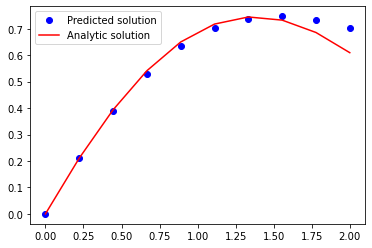

In [17]:
sol = X_train + tf.multiply(tf.square(X_train), forward_propagation(X_train, parameters)[0])
print(sol)
plt.plot(X_train.numpy()[0], sol.numpy()[0], "ob", label="Predicted solution")
plt.plot(X_train.numpy()[0], Y_train.numpy()[0], "-r", label="Analytic solution")
plt.legend()
plt.show()

In [18]:
error = tf.abs(Y_train - sol)
error

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.        , 0.0010919 , 0.00488386, 0.01076823, 0.01594973,
        0.01611793, 0.00689214, 0.01468086, 0.04907751, 0.09387034]],
      dtype=float32)>

In [19]:
from sklearn.metrics import r2_score

r2_score(np.squeeze(Y_train.numpy()), np.squeeze(sol.numpy()))

0.9786572163243357